I think the most obvious advantage of using AI as a companion for writing code is that it is highly efficient in completing tasks. All I need to do is tell it what I want to do, copy and paste, and then verify whether the code is feasible. Secondly, when debugging, you just need to copy and paste the error message to the AI, and it can immediately identify the problem. However, when my prompts are not precise enough, it can lead to the code not running or not fully meeting my needs. This was particularly evident when I tried Claude.ai. After countless failures, I eventually switched to ChatGPT for use, generating more reliable and immediately running code, but only after I practiced giving clear and specific instructions. 

The effect of generative artificial intelligence as a collaborator is actually very good: it can improve the efficiency of our code writing (only when I know what I want to write), and it must be guided by detailed prompts and its output must always be verified. Moreover, I clearly know that I cannot rely on AI for code practice. I can clearly feel that I haven't thought much during the process of using AI to write code and haven't made any progress of my own.

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
脚本功能：从 Female detainees' records.html 中提取案件链接并生成 CSV
"""

import re
from bs4 import BeautifulSoup
import pandas as pd

# 1. 读取 HTML 文件（注意页面声明的是 windows-1252 编码）
with open("Female detainees' records.html", encoding="windows-1252") as f:
    html = f.read()

# 2. 使用 BeautifulSoup 解析 HTML
soup = BeautifulSoup(html, "lxml")
body = soup.body

# 3. 找到所有 <a> 标签
all_links = body.find_all("a")

# 4. 过滤出以 “Case <数字>” 开头的链接
case_links = []
case_pattern = re.compile(r"^Case\s+\d+", re.IGNORECASE)
for a in all_links:
    txt = a.get_text(strip=True)
    if case_pattern.match(txt):
        case_links.append(a)

# 5. 从每个链接中提取 case_number, description, url
records = []
for a in case_links:
    txt = a.get_text(" ", strip=True)      # 如 "Case 2657 Moy Chin See his wife"
    href = a.get("href")                   # 如 "https://www.frederickbee.com/2657.html"
    m = re.match(r"Case\s+(\d+)\s+(.*)", txt, re.IGNORECASE)
    if not m:
        continue
    records.append({
        "case_number": m.group(1),
        "description": m.group(2),         # 如 "Moy Chin See his wife"
        "url": href
    })

# 6. 转为 pandas DataFrame
df = pd.DataFrame(records)

# 7. 去重（如果同一 case_number 出现多次，则保留第一次）
df = df.drop_duplicates(subset="case_number", keep="first")

# 8. 排除“appeal”、“Testimony”、“records”等非主诉求条目
exclude_re = re.compile(r"appeal|testimony|records", re.IGNORECASE)
df = df[~df["description"].str.contains(exclude_re)]

# 9. （可选）进一步拆分姓名和其他说明，需要人工检查正则是否覆盖所有情况
# df[["name", "extra"]] = df["description"].str.extract(r"^([\w\s\.\']+)(.*)$", expand=True)

# 10. 导出为 CSV（UTF-8 编码）
output_file = "female_detainees_cases_1882_1892.csv"
df.to_csv(output_file, index=False, encoding="utf-8")

print(f"提取完成，文件已保存为：{output_file}")


提取完成，文件已保存为：female_detainees_cases_1882_1892.csv


In [7]:
ha_df = pd.read_csv('habeas-corpus-cases-1889-1892.csv')

In [9]:
sample_df = ha_df.sample(n=20, random_state=42)
sample_df.to_csv('habeas_corpus_sample.csv', index=False)

In [30]:
import pandas as pd
import numpy as np
import re

# Step 1: Load data
df = pd.read_csv('habeas-corpus-cases-1889-1892.csv')

# Step 2: Normalize column names
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r'\s+', '_', regex=True)
)

# Step 3: Drop empty steam_ship_number column if present
if 'steam_ship_number' in df.columns and df['steam_ship_number'].str.strip().eq('').all():
    df = df.drop(columns=['steam_ship_number'])

# Step 4: Replace empty strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# Step 5: Rename columns for clarity
df = df.rename(columns={
    'for_relief_of': 'petitioner',
    'character_of_case': 'case_character',
    'by_whom_or_where_detained': 'detained_by',
    'attorney_for_petition': 'attorney',
    'name_of_father': 'father_name',
    'age_or_year_of_birth': 'age_or_birth'
})

# Step 6: Convert numeric types
df['case_number'] = df['case_number'].astype(int)
df['year'] = df['year'].astype(int)

# Step 7: Drop duplicate records based on case_number
df = df.drop_duplicates(subset=['case_number'])

# Step 8: Standardize text fields (strip + lowercase)
text_cols = ['petitioner', 'case_character', 'detained_by', 'attorney', 'remarks', 'father_name', 'address', 'age_or_birth']
for col in text_cols:
    df[col] = df[col].str.strip().str.lower()

# Step 9: Split address into street_number and street_name
df[['street_number', 'street_name']] = df['address'].str.extract(r'(\d+)\s+(.*)')

# Step 10: Split names into last_name and first_name
df[['petitioner_last_name', 'petitioner_first_name']] = df['petitioner'].str.split(pat=' ', n=1, expand=True)
df[['father_last_name', 'father_first_name']]     = df['father_name'].str.split(pat=' ', n=1, expand=True)


# Step 11: Parse age or birth year, compute both fields
def parse_age_or_birth(x, record_year):
    if pd.isna(x):
        return pd.NA, pd.NA
    x = x.lower()
    # find all digit groups
    nums = re.findall(r'\d+', x)
    if not nums:
        return pd.NA, pd.NA
    val = nums[0]
    # if it's a four-digit year, treat as birth year
    if len(val) == 4:
        birth_year = int(val)
        age = record_year - birth_year
    else:
        age = int(val)
        birth_year = record_year - age
    return birth_year, age

parsed = df.apply(lambda row: parse_age_or_birth(row['age_or_birth'], row['year']), axis=1)
df['birth_year'] = [p[0] for p in parsed]
df['age'] = [p[1] for p in parsed]

# Step 12: Export cleaned data
df.to_csv('habeas_corpus_cleaned.csv', index=False)

# Inspect result
print(df.info())
print(df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   case_number            1284 non-null   int32 
 1   year                   1284 non-null   int32 
 2   petitioner             1284 non-null   object
 3   case_character         1278 non-null   object
 4   detained_by            1280 non-null   object
 5   attorney               1284 non-null   object
 6   remarks                1273 non-null   object
 7   father_name            1249 non-null   object
 8   address                1270 non-null   object
 9   age_or_birth           1239 non-null   object
 10  street_number          1086 non-null   object
 11  street_name            1086 non-null   object
 12  petitioner_last_name   1284 non-null   object
 13  petitioner_first_name  1284 non-null   object
 14  father_last_name       1249 non-null   object
 15  father_first_name    

In [34]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv('habeas_corpus_cleaned.csv')

# Select 25 random rows
sample_df = df.sample(n=25)

# Save the sample to a new CSV file
sample_df.to_csv('sample_habeas_corpus_cases.csv', index=False)


Habeas corpus cases filed per year (1889–1892):
year
1889     171
1890    1065
1891      32
1892      16


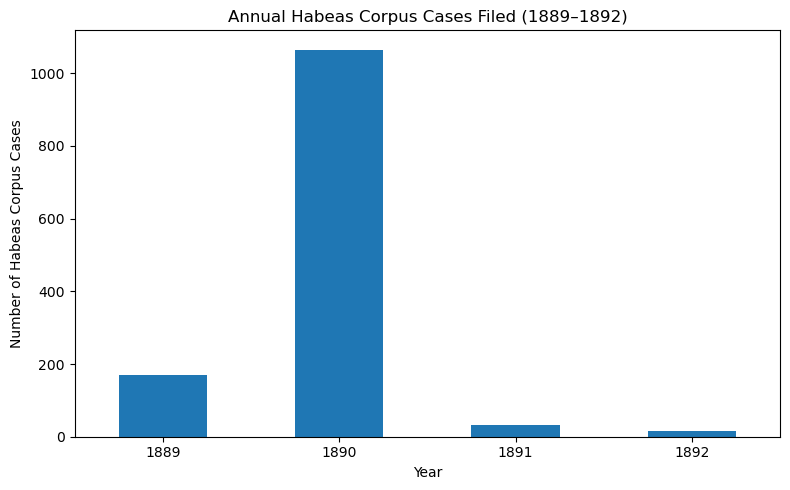

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the dataset (update the path to wherever you saved the CSV)
df = pd.read_csv('habeas_corpus_cleaned.csv')

# 2. Coerce the 'year' column to numeric, turning any bad/missing entries into NaN
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# 3. Drop rows where 'year' is NaN (i.e. missing or non‑numeric)
df_clean = df.dropna(subset=['year'])

# 4. Convert 'year' from float to int now that invalids are gone
df_clean['year'] = df_clean['year'].astype(int)

# 5. Filter to only the years 1889 through 1892
df_filtered = df_clean[(df_clean['year'] >= 1889) & (df_clean['year'] <= 1892)]

# 6. Count how many cases in each year, sorted chronologically
cases_per_year = df_filtered['year'].value_counts().sort_index()

# 7. Print the counts so you can inspect them in the console
print("Habeas corpus cases filed per year (1889–1892):")
print(cases_per_year.to_string())

# 8. Visualize with a bar chart
plt.figure(figsize=(8, 5))
cases_per_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Habeas Corpus Cases')
plt.title('Annual Habeas Corpus Cases Filed (1889–1892)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [40]:
import pandas as pd

# 1. Load the dataset (update the path as needed)
df = pd.read_csv('habeas_corpus_cleaned.csv')

# 2. Ensure the 'petitioner' column is a string, so that .str operations won’t error
df['petitioner'] = df['petitioner'].astype(str)

# 3. Build a boolean mask for rows where “(female)” appears (case‑insensitive)
#    na=False means that any missing petitioner will count as False rather than error
female_mask = df['petitioner'].str.contains(r'\(female\)', case=False, na=False)

# 4. Sum up how many True’s there are
female_count = female_mask.sum()

# 5. (Optional) See the total number of records and proportion
total_records = len(df)
pct_female = female_count / total_records * 100

# 6. Print out the results
print(f"Women in dataset (noted by “(female)”): {female_count}")
print(f"Total records: {total_records}")
print(f"Share female: {pct_female:.2f}%")


Women in dataset (noted by “(female)”): 127
Total records: 1284
Share female: 9.89%


In [42]:
import pandas as pd

# 1. Load the cleaned dataset
#    (make sure this file is in your working directory, or adjust the path)
df = pd.read_csv('habeas_corpus_cleaned.csv')

# 2. Normalize the 'remarks' column: force to string, lowercase, and strip whitespace
df['remarks'] = df['remarks'].astype(str).str.lower().str.strip()

# 3. Count each distinct outcome
outcome_counts = df['remarks'].value_counts()

# 4. Pull out the two you care about (defaults to 0 if missing)
remanded_count = outcome_counts.get('remanded', 0)
discharged_count = outcome_counts.get('discharged', 0)

# 5. Print the results
print(f"Number of detainees remanded to prison: {remanded_count}")
print(f"Number of detainees discharged (allowed to go free): {discharged_count}")


Number of detainees remanded to prison: 496
Number of detainees discharged (allowed to go free): 723


In [44]:
import pandas as pd

# 1. Load your cleaned dataset
df = pd.read_csv('habeas_corpus_cleaned.csv')

# 2. Make sure 'address' is treated as text
df['address'] = df['address'].astype(str)

# 3. Split on commas (up to two splits → 3 parts max)
#    e.g. "123 Main St, Oakland, CA" → ["123 Main St", " Oakland", " CA"]
address_parts = df['address'].str.split(',', n=2, expand=True)

# 4. Assign the new columns, stripping extra whitespace
df['Street_Address'] = address_parts[0].str.strip()
df['City']           = address_parts[1].str.strip()
df['State']          = address_parts[2].str.strip()

# 5. Fill in missing cities with "San Francisco"
#    (any row where no comma was present will have NaN here)
df['City'] = df['City'].fillna('San Francisco')

# 6. Fill in missing states with "CA"
df['State'] = df['State'].fillna('CA')

# 7. (Optional) If you no longer need the original 'address' column:
# df = df.drop(columns=['address'])

# 8. Inspect the result
print(df[['Street_Address', 'City', 'State']].head())


  Street_Address           City State
0     726 dupont  San Francisco    CA
1     716 dupont  San Francisco    CA
2    los angeles  San Francisco    CA
3     826 dupont  San Francisco    CA
4    1009 dupont  San Francisco    CA


Age distribution of detainees:
computed_age
4        1
5        2
6        1
7        1
9        4
10       8
11       4
12      22
13      27
14      47
15      58
16      57
17      48
18      63
19      78
20      95
21     152
22     156
23     132
24     103
25      58
26      43
27      39
28      24
29       4
30       6
31       1
32       3
201      1
222      1

Summary statistics:
count    1239.000000
mean       20.859564
std         8.732683
min         4.000000
25%        18.000000
50%        21.000000
75%        23.000000
max       222.000000


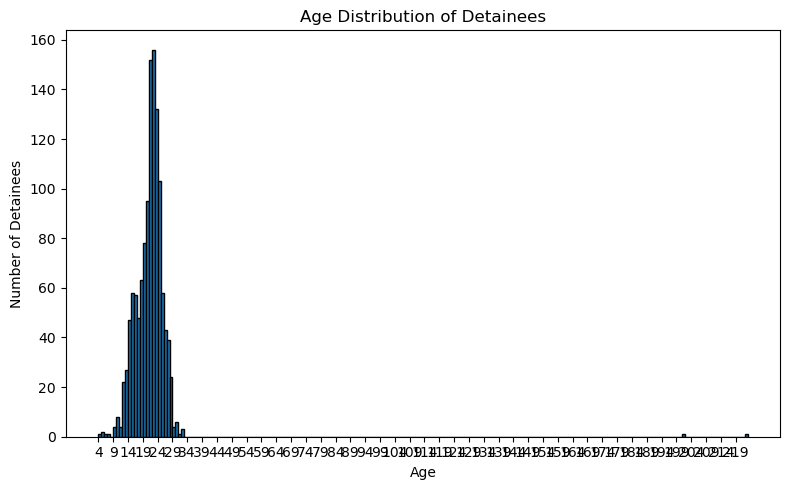

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your cleaned dataset (adjust path if needed)
df = pd.read_csv('habeas_corpus_cleaned.csv')

# 2. Coerce to numeric, turning any invalids into NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['birth_year'] = pd.to_numeric(df['birth_year'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')  # filing year

# 3. Create a unified age column:
#    - use 'age' when available
#    - otherwise compute as (filing year - birth_year)
df['computed_age'] = df['age']  # start with whatever’s in 'age'
mask = df['computed_age'].isna() & df['birth_year'].notna() & df['year'].notna()
df.loc[mask, 'computed_age'] = df.loc[mask, 'year'] - df.loc[mask, 'birth_year']

# 4. Drop any rows where we still couldn’t get an age
df_age = df.dropna(subset=['computed_age']).copy()

# 5. Convert to integer (ages should be whole years)
df_age['computed_age'] = df_age['computed_age'].astype(int)

# 6. Get the raw counts for each age
age_counts = df_age['computed_age'].value_counts().sort_index()

# 7. Print the age distribution
print("Age distribution of detainees:")
print(age_counts.to_string())

# 8. (Optional) Summary statistics
print("\nSummary statistics:")
print(df_age['computed_age'].describe().to_string())

# 9. Plot a histogram of the age distribution
plt.figure(figsize=(8, 5))
plt.hist(
    df_age['computed_age'],
    bins=range(df_age['computed_age'].min(), df_age['computed_age'].max() + 2),
    edgecolor='black'
)
plt.xlabel('Age')
plt.ylabel('Number of Detainees')
plt.title('Age Distribution of Detainees')
plt.xticks(range(df_age['computed_age'].min(), df_age['computed_age'].max() + 1, 5))
plt.tight_layout()
plt.show()
